## Finetune pretrained models

For dog breed identification, it is recommended to fine tune from the ImageNet pretrained models and for only the last layer. Reasons are:
- The provided training set is quite small while the number of classes is quite big. 
- ImageNet dataset contains lots of dogs. So we assumed the pretrained models have already been trained to recognition dogs.

Reference: 
- https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [41]:
pip list

Package                            Version    
---------------------------------- -----------
alabaster                          0.7.12     
anaconda-client                    1.7.2      
anaconda-navigator                 1.9.6      
anaconda-project                   0.8.2      
asn1crypto                         0.24.0     
astroid                            2.1.0      
astropy                            3.1        
atomicwrites                       1.2.1      
attrs                              18.2.0     
Babel                              2.6.0      
backcall                           0.1.0      
backports.os                       0.1.1      
backports.shutil-get-terminal-size 1.0.0      
bcolz                              1.2.1      
beautifulsoup4                     4.6.3      
bitarray                           0.8.3      
bkcharts                           0.2        
blaze                              0.11.3     
bleach                             3.0.2      
bokeh        

Note: you may need to restart the kernel to use updated packages.


In [42]:
import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import DataLoader
import torch
import torchvision
import sys
print(sys.version)
print(sys.path)
sys.executable
# import imgaug


3.7.1 (default, Dec 14 2018, 19:28:38) 
[GCC 7.3.0]
['/home/tensor_of/ndsc/ndsc', '/opt/anaconda3/lib/python37.zip', '/opt/anaconda3/lib/python3.7', '/opt/anaconda3/lib/python3.7/lib-dynload', '', '/opt/anaconda3/lib/python3.7/site-packages', '/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/root/.ipython']


'/opt/anaconda3/bin/python'

In [43]:
%load_ext autoreload
%autoreload 2

from src.data import TrainDataset
from src.data import get_test_time_transform, get_train_time_transform_simple, get_train_time_transform
from src.utils import show_data_batch
from src.run import train_model
from src.model import initialize_model, get_model_input_size

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## data inputs

In [44]:
# set the path and directory for train and validation
train_dataset_csv = 'processed_data/train_train.csv'
val_dataset_csv = 'processed_data/train_val.csv'
train_root_dir = 'datasets'
test_root_dir = 'datasets'

## training settings

In [45]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = 'resnet50'
input_size = get_model_input_size(model_name)

# Number of classes in the dataset
num_classes = 58

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for 
num_epochs = 10

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

## load datasets

In [46]:
crop_size = input_size
# we use (scale_size: 256, crop_size: 224) and (scale_size: 320, crop_size: 299)
# for resize and cropping
scale_size = 320 if input_size == 299 else 256

print('input size: {} scale size: {} crop size: {}'.format(input_size, scale_size, crop_size))

input size: 224 scale size: 256 crop size: 224


In [47]:
# transforms settings
train_transform_aug = get_train_time_transform(scale_size=scale_size, crop_size=crop_size)
train_transform_simple = get_train_time_transform_simple(scale_size=scale_size, crop_size=crop_size)
test_transform = get_test_time_transform(scale_size=crop_size, crop_size=crop_size)

In [48]:
# datasets with transforms
train_dataset_simple = TrainDataset(
    csv_file=train_dataset_csv, root_dir=train_root_dir, transform=train_transform_simple)
train_dataset_aug = TrainDataset(
    csv_file=train_dataset_csv, root_dir=train_root_dir, transform=train_transform_aug)
val_dataset = TrainDataset(
    csv_file=val_dataset_csv, root_dir=train_root_dir, transform=test_transform)

In [49]:
# data loaders
train_data_loader_simple = DataLoader(
    train_dataset_simple, batch_size=batch_size, shuffle=True, num_workers=4)
train_data_loader_aug = DataLoader(
    train_dataset_aug, batch_size=batch_size, shuffle=True, num_workers=4)
val_data_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# data loaders in dict
data_loaders_simple = {
    'train': train_data_loader_simple,
    'val': val_data_loader
}

data_loaders_aug = {
    'train': train_data_loader_aug,
    'val': val_data_loader
}

### test your data loader before training

0 torch.Size([32, 3, 224, 224]) torch.Size([32])


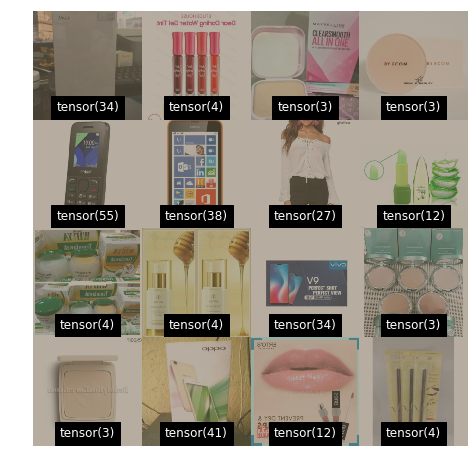

In [50]:
for batch_idx, batch_data in enumerate(train_data_loader_aug):
    print(batch_idx, batch_data['image'].size(), batch_data['label'].size())
    show_data_batch(batch_data, figsize=(8, 8))
    break

### also check your device

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('you are using device: ', device)

you are using device:  cuda:0


## initialize the model

In [52]:
# Initialize the model for this run
model_ft = initialize_model(
    model_name=model_name, num_classes=num_classes, feature_extract=feature_extract, 
    use_pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
46827520it [00:00, 81732167.13it/s]
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 89333390.17it/s]
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 90041733.41it/s]
Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.torch/models/resnet101-5d3b4d8f.pth
178728960it [00:01, 90501973.26it/s]
Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
241530880it [00:02, 88809528.79it/s]


In [53]:
# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## finetune only the last layer

In [54]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
# define your loss type
logloss_criterion = torch.nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
# sgd_optimizer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)
adam_optimizer = torch.optim.Adam(params_to_update, lr=0.0005, weight_decay=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(sgd_optimizer, step_size=5, gamma=0.1)

### 1. simple transformation

In [ ]:
# model training
trained_model, full_performance_history = train_model(
    model=model_ft, device=device, dataloaders=data_loaders_simple, 
    criterion=logloss_criterion, optimizer=adam_optimizer, scheduler=None, 
    num_epochs=num_epochs, is_inception=False, in_notebook=True)

Epoch 0/9
----------


In [ ]:
# save the trained model
# Training complete in 7m 48s
# Best validation Loss: 0.740628 Acc: 0.8553

# adam
# Training complete in 7m 42s
# Best validation Loss: 0.718583 Acc: 0.8514
# 0.001
# Training complete in 11m 2s
# Best validation Loss: 0.522613 Acc: 0.8426
# 0.0005
# Training complete in 11m 14s
# Best validation Loss: 0.514895 Acc: 0.8368
torch.save(trained_model.state_dict(), 'model/resnet50_fe_adam_10epoch_simple_0.0005.pt')

In [ ]:
display(full_performance_history.head())

In [ ]:
# save the history
full_performance_history.to_csv('model/resnet50_fe_adam_10epoch_simple_0.0005_history.csv', index=False)

### 2. with rich data augmentation
Remember to re-initialize your model.

In [31]:
# model training
trained_model_aug, full_performance_history_aug = train_model(
    model=model_ft, device=device, dataloaders=data_loaders_aug, 
    criterion=logloss_criterion, optimizer=adam_optimizer, scheduler=None,
    num_epochs=num_epochs, is_inception=True, in_notebook=True)

Epoch 0/9
----------


Epoch 0 train Loss: 6.0835 Acc: 0.1646


Epoch 0 val Loss: 3.7659 Acc: 0.6520

Epoch 1/9
----------


Epoch 1 train Loss: 4.8963 Acc: 0.4742


Epoch 1 val Loss: 2.9541 Acc: 0.7458

Epoch 2/9
----------


Epoch 2 train Loss: 4.0212 Acc: 0.5856


Epoch 2 val Loss: 2.2959 Acc: 0.8006

Epoch 3/9
----------


Epoch 3 train Loss: 3.3791 Acc: 0.6397


Epoch 3 val Loss: 1.8061 Acc: 0.8201

Epoch 4/9
----------


Epoch 4 train Loss: 2.9332 Acc: 0.6642


Epoch 4 val Loss: 1.4516 Acc: 0.8426

Epoch 5/9
----------


Epoch 5 train Loss: 2.6013 Acc: 0.6788


Epoch 5 val Loss: 1.2050 Acc: 0.8514

Epoch 6/9
----------


Epoch 6 train Loss: 2.3609 Acc: 0.6928


Epoch 6 val Loss: 1.0184 Acc: 0.8583

Epoch 7/9
----------


Epoch 7 train Loss: 2.1651 Acc: 0.7037


Epoch 7 val Loss: 0.9128 Acc: 0.8583

Epoch 8/9
----------


Epoch 8 train Loss: 2.0261 Acc: 0.7086


Epoch 8 val Loss: 0.8251 Acc: 0.8602

Epoch 9/9
----------


Epoch 9 train Loss: 1.9229 Acc: 0.7198


Epoch 9 val Loss: 0.7478 Acc: 0.8671


Training complete in 10m 55s
Best validation Loss: 0.747809 Acc: 0.8671


In [32]:
# save the trained model
# Training complete in 11m 7s
# Best validation Loss: 0.753590 Acc: 0.8573

# adam with aug
# Training complete in 10m 55s
# Best validation Loss: 0.747809 Acc: 0.8671
torch.save(trained_model_aug.state_dict(), 'model/dog_breed_fe_adam_10epoch_aug.pt')

In [33]:
# save the history
full_performance_history_aug.to_csv('model/dog_breed_fe_adam_10epoch_aug_history.csv', index=False)